## Bibliotecas

In [36]:
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from google.colab                import drive

In [37]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
df_segmentacao = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/Segmentação de Clientes/online_retail_II.xlsx')
df_segmentacao.shape

(525461, 8)

In [39]:
df_segmentacao.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [40]:
df_segmentacao.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

## Tratamento de dados

In [41]:
#Retiramos dados nulos de consumidores
df_segmentacao = df_segmentacao[~df_segmentacao['Customer ID'].isna()].drop('Description', axis=1)

In [42]:
#Verificamos que existem quantidades negativas de compras
df_segmentacao = df_segmentacao[~df_segmentacao['Quantity'] < 1]

In [43]:
#Retiramos dados de clientes que tiveram compra com valor nulo
df_segmentacao = df_segmentacao[df_segmentacao['Price'] != 0]

In [44]:
#Intervalo de tempo da base de dados
df_segmentacao['InvoiceDate'].agg(['min', 'max'])

#A data máxima será a medida final do intervalo de recencia
data_máxima = max(df_segmentacao['InvoiceDate'])

In [45]:
df_segmentacao['Customer ID'] = df_segmentacao['Customer ID'].astype(int).astype(str)
df_segmentacao.shape

(411981, 7)

In [46]:
#Quantidade de clientes únicos pertencentes a base de dados
len(df_segmentacao['Customer ID'].unique().tolist())

4362

In [47]:
df_segmentacao.dtypes

Invoice                object
StockCode              object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

In [48]:
#Criar análise de RFM para a base de clientes
df_segmentacao['Amount'] = df_segmentacao['Price'] * df_segmentacao['Quantity']

In [49]:
df_segmentacao.columns

Index(['Invoice', 'StockCode', 'Quantity', 'InvoiceDate', 'Price',
       'Customer ID', 'Country', 'Amount'],
      dtype='object')

## [EDA]

In [50]:
df_segmentacao.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [15]:
#Indicadores
### Análise de cohort
### Ranking de lugares com maiores quantidades de venda


## RFM Analytcs

In [16]:
#Cria feature de montante transacionado
df_monetary = df_segmentacao.groupby('Customer ID')['Amount'].sum().reset_index()

#Cria feature de invoice consumida
df_frequency = df_segmentacao.groupby('Customer ID')['Invoice'].count().reset_index()


#Junta as features tratadas
rfm_dataframe = df_monetary.merge(df_frequency, on='Customer ID')

In [17]:
#Trazer feature de recência de cada consumidor
df_segmentacao['Recency'] = data_máxima - df_segmentacao['InvoiceDate']

#Buscamos a data mínima em dias de cada cliente
df_recency = df_segmentacao.groupby('Customer ID')['Recency'].min().reset_index()

#Tratamos a data
df_recency['Recency'] = df_recency['Recency'].dt.days

In [18]:
rfm_dataframe = rfm_dataframe.merge(df_recency, on='Customer ID')

In [19]:
#Quantidade de consumidores únicos
len(rfm_dataframe['Customer ID'].unique().tolist())

4362

In [20]:
# removing outliers
# outlier treatment for amount
Q1 = rfm_dataframe.Amount.quantile(0.05)
Q3 = rfm_dataframe.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Amount >= Q1 - 1.5*IQR) & (rfm_dataframe.Amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = rfm_dataframe.Recency.quantile(0.05)
Q3 = rfm_dataframe.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Recency >= Q1 - 1.5*IQR) & (rfm_dataframe.Recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = rfm_dataframe.Invoice.quantile(0.05)
Q3 = rfm_dataframe.Invoice.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Invoice >= Q1 - 1.5*IQR) & (rfm_dataframe.Invoice <= Q3 + 1.5*IQR)]

In [21]:
len(rfm_dataframe['Customer ID'].unique().tolist())

4277

## [Exp.1] RFM Score

In [22]:
rfm_dataframe["R_Score"] = pd.qcut(rfm_dataframe["Recency"],5,labels=[5,4,3,2,1])
rfm_dataframe["F_Score"] = pd.qcut(rfm_dataframe["Invoice"].rank(method="first"),5, labels=[1,2,3,4,5])
rfm_dataframe["M_Score"] = pd.qcut(rfm_dataframe["Amount"],5,labels=[1,2,3,4,5])
rfm_dataframe["RFM_Score"] = rfm_dataframe["R_Score"].astype(str) + rfm_dataframe["F_Score"].astype(str) + rfm_dataframe["M_Score"].astype(str)

rfm_dataframe.head()

,Customer ID,Amount,Invoice,Recency,R_Score,F_Score,M_Score,RFM_Score
0,12346,27.02,44,66,3,3,1,331
1,12347,1323.32,71,2,5,4,4,544
2,12348,222.16,20,73,2,2,1,221
3,12349,2646.99,107,42,3,4,5,345
4,12351,300.93,21,10,5,2,2,522


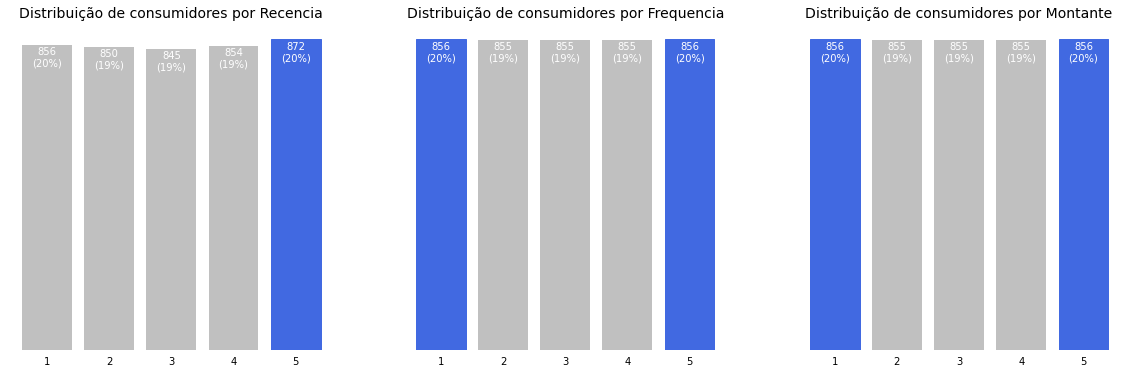

In [62]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

for i, p in enumerate(['R_Score', 'F_Score','M_Score']):
    parameters = {'R_Score':'Recencia', 'F_Score':'Frequencia', 'M_Score':'Montante'}
    y = rfm_dataframe[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribuição de consumidores por {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('royalblue')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

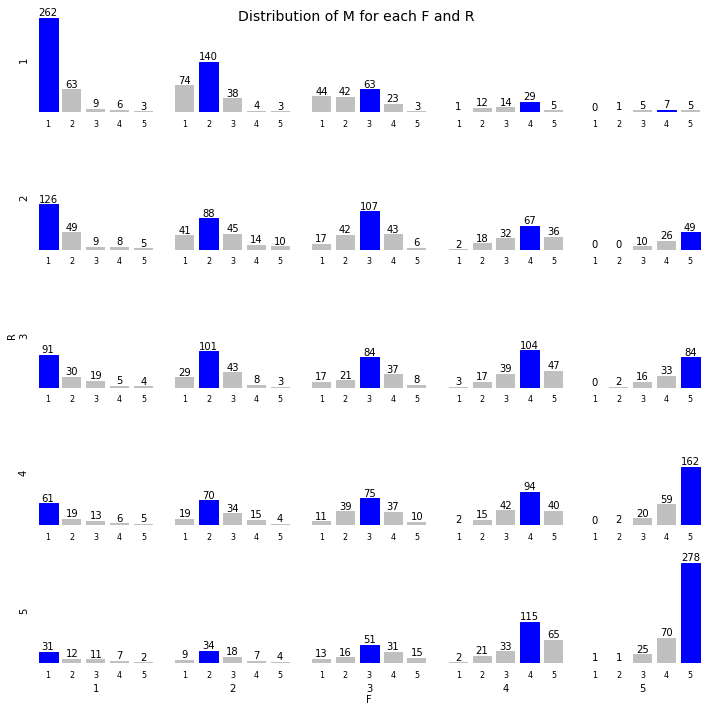

In [57]:
# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm_dataframe[(rfm_dataframe['R_Score'] == r) & (rfm_dataframe['F_Score'] == f)]['M_Score'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('Blue')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()